In [1]:
import numpy as np
import pandas as pd
import sklearn
import sklearn.preprocessing, sklearn.cluster, sklearn.metrics
import scipy.spatial
import matplotlib.pyplot as plt
import seaborn as sns

### Load titanic dataset

In [4]:
df = pd.read_csv('titanic.csv')

In [5]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### How many missing values are in there?

In [6]:
df.isna().sum().sort_values()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Embarked         2
Age            177
Cabin          687
dtype: int64

### Lets try to encode categorical features
- https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing
- https://scikit-learn.org/stable/modules/classes.html?highlight=preprocessing#module-sklearn.preprocessing

Which categorical features need to be encoded?

- Doplnění na základě klasifikace
- Průměr

In [9]:
df_clustering = df[['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']]
df_clustering = df_clustering.dropna()
df_clustering.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


### Let's scale number features

Kolik máme záznamů?

In [10]:
df_clustering.shape

(712, 8)

In [12]:
df_clustering.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000
mean,0.404494,2.240169,29.642093,0.514045,0.432584,34.567251
std,0.491139,0.836854,14.492933,0.930692,0.854181,52.938648
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,20.000000,0.000000,0.000000,8.050000
50%,0.000000,2.000000,28.000000,0.000000,0.000000,15.645850
75%,1.000000,3.000000,38.000000,1.000000,1.000000,33.000000
max,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


## Clustering

Use any clustering method for preprocessed data

### Jak kodovat?

- Základní
- Vyšší

In [14]:
df.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [17]:
enc = sklearn.preprocessing.OrdinalEncoder()
enc.fit_transform(df_clustering[['Sex']])[:20]

array([[1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.]])

In [18]:
enc.categories_

[array(['female', 'male'], dtype=object)]

In [19]:
enc2 = sklearn.preprocessing.OneHotEncoder(sparse=False)
enc2.fit_transform(df_clustering[['Embarked']])

array([[0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.]])

In [21]:
pd.get_dummies(df_clustering[['Embarked']])

,Embarked_C,Embarked_Q,Embarked_S
0,0,0,1
1,1,0,0
2,0,0,1
3,0,0,1
4,0,0,1
...,...,...,...
885,0,1,0
886,0,0,1
887,0,0,1
889,1,0,0


In [22]:
df_encoded = pd.DataFrame(index=df_clustering.index)

- Problém s tím že nevíme jak se co zakodovalo?

In [24]:
df_encoded['Sex'] = sklearn.preprocessing.OrdinalEncoder().fit_transform(df_clustering[['Sex']])

In [ ]:
df_encoded = df_encoded.join(pd.get_dummies(df_clustering[['Embarked']]))

In [28]:
df_encoded.head()

,Sex,Embarked_C,Embarked_Q,Embarked_S
0,1.0,0,0,1
1,0.0,1,0,0
2,0.0,0,0,1
3,0.0,0,0,1
4,1.0,0,0,1


<AxesSubplot:>

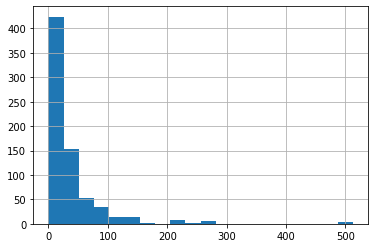

In [30]:
df_clustering.Fare.hist(bins=20)

<AxesSubplot:>

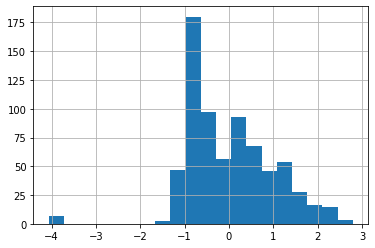

In [32]:
df_encoded['Fare'] = sklearn.preprocessing.PowerTransformer().fit_transform(df_clustering[['Fare']])
df_encoded.Fare.hist(bins=20)

## Explore clusters

Try to use cluster information and exploration analysis of our data.

- One hot encoding udělá větší vzdálenost než je potřeba
- Embarked jsou jakoby dva atributy a (1-0) + (1-0) = 2.. přičemž chceme raději vzdálenost 1

In [33]:
df_encoded['Age'] = sklearn.preprocessing.minmax_scale(df_clustering.Age)
df_encoded = df_encoded.join(df_clustering[['Survived', 'Pclass', 'SibSp', 'Parch']])
df_encoded.head()

,Sex,Embarked_C,Embarked_Q,Embarked_S,Fare,Age,Survived,Pclass,SibSp,Parch
0,1.0,0,0,1,-0.997650,0.271174,0,3,1,0
1,0.0,1,0,0,1.287757,0.472229,1,1,1,0
2,0.0,0,0,1,-0.901073,0.321438,1,3,0,0
3,0.0,0,0,1,1.024276,0.434531,1,1,1,0
4,1.0,0,0,1,-0.884112,0.434531,0,3,0,0


# Clustering

In [34]:
X = df_encoded.values

<AxesSubplot:xlabel='k'>

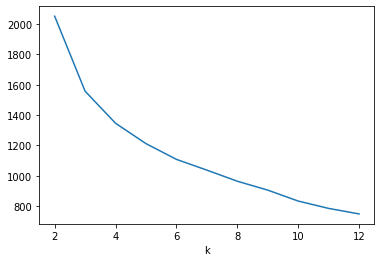

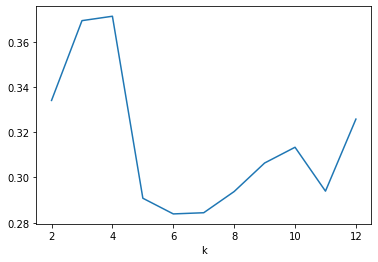

In [38]:
clustering_scores = []

for k in range(2, 13):
    clustering = sklearn.cluster.KMeans(n_clusters=k).fit(X)
    clustering_scores.append({
        'k': k,
        'sse': clustering.inertia_,
        'silh': sklearn.metrics.silhouette_score(X, clustering.labels_)
    })
    
    
df_scores = pd.DataFrame.from_dict(clustering_scores, orient='columns').set_index('k')



df_scores.sse.plot()
plt.figure()
df_scores.silh.plot()

In [40]:
clustering = sklearn.cluster.KMeans(n_clusters=4).fit(X)

In [41]:
pd.Series(clustering.labels_).value_counts()

0    398
2    182
1     97
3     35
dtype: int64

# Explore clusters

In [42]:
df_clustering['clusterId'] = clustering.labels_
df_clustering.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,clusterId
0,0,3,male,22.0,1,0,7.2500,S,0
1,1,1,female,38.0,1,0,71.2833,C,2
2,1,3,female,26.0,0,0,7.9250,S,0
3,1,1,female,35.0,1,0,53.1000,S,2
4,0,3,male,35.0,0,0,8.0500,S,0


<AxesSubplot:xlabel='clusterId', ylabel='count'>

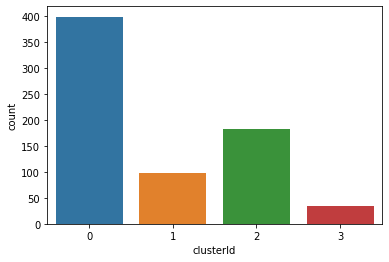

In [43]:
sns.countplot(data=df_clustering, x='clusterId')

<AxesSubplot:xlabel='clusterId', ylabel='count'>

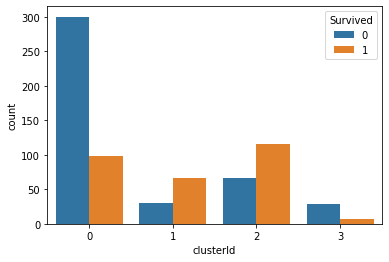

In [44]:
sns.countplot(data=df_clustering, x='clusterId', hue='Survived')

<AxesSubplot:xlabel='clusterId', ylabel='count'>

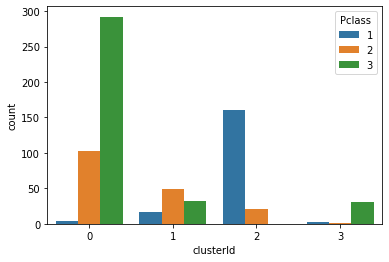

In [45]:
sns.countplot(data=df_clustering, x='clusterId', hue='Pclass')

- z rychliku
- kouzelna formule :D

In [48]:
with pd.option_context('display.max_columns', None):
    display(df_clustering.groupby('clusterId').describe())

Survived                                              Pclass  \
             count      mean       std  min  25%  50%  75%  max  count   
clusterId                                                                
0            398.0  0.246231  0.431357  0.0  0.0  0.0  0.0  1.0  398.0   
1             97.0  0.690722  0.464597  0.0  0.0  1.0  1.0  1.0   97.0   
2            182.0  0.637363  0.482088  0.0  0.0  1.0  1.0  1.0  182.0   
3             35.0  0.200000  0.405840  0.0  0.0  0.0  0.0  1.0   35.0   

                                                          Age             \
               mean       std  min  25%  50%  75%  max  count       mean   
clusterId                                                                  
0          2.723618  0.469734  1.0  2.0  3.0  3.0  3.0  398.0  28.953317   
1          2.164948  0.687393  1.0  2.0  2.0  3.0  3.0   97.0  22.853093   
2          1.115385  0.320367  1.0  1.0  1.0  1.0  2.0  182.0  38.571429   
3          2.800000  0.584103  1.0  3.0  3.0  3.0  3.0   35.0   9.857143   

                                                       SibSp            \
                 std    min   25%   50%     75%   max  count      mean   
clusterId                                                                
0          11.769346   0.42  21.0  27.0  34.875  74.0  398.0  0.188442   
1          15.959488   0.67   7.0  24.0  36.000  64.0   97.0  0.762887   
2          13.853829  14.00  28.0  36.5  49.000  80.0  182.0  0.461538   
3           8.203811   1.00   3.5   8.0  14.000  33.0   35.0  3.800000   

                                              Parch                           \
                std  min  25%  50%  75%  max  count      mean       std  min   
clusterId                                                                      
0          0.434260  0.0  0.0  0.0  0.0  2.0  398.0  0.072864  0.260241  0.0   
1          0.657856  0.0  0.0  1.0  1.0  2.0   97.0  1.938144  1.116304  1.0   
2          0.562310  0.0  0.0  0.0  1.0  2.0  182.0  0.203297  0.442731  0.0   
3          0.677365  3.0  3.0  4.0  4.0  5.0   35.0  1.542857  0.610827  0.0   

                                Fare                                          \
           25%  50%  75%  max  count       mean        std      min      25%   
clusterId                                                                      
0          0.0  0.0  0.0  1.0  398.0  11.024570   6.510430   0.0000   7.7958   
1          1.0  2.0  2.0  6.0   97.0  45.400687  51.028040  11.1333  20.5750   
2          0.0  0.0  0.0  2.0  182.0  76.987157  74.577792  24.0000  30.0708   
3          1.0  2.0  2.0  2.0   35.0  51.673571  66.280456   7.9250  27.9000   

                                        
               50%       75%       max  
clusterId                               
0           8.6625  13.00000   56.4958  
1          27.0000  39.00000  263.0000  
2          56.9646  85.74375  512.3292  
3          31.2750  39.68750  263.0000

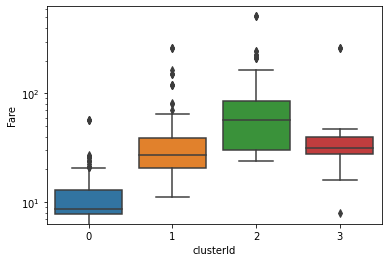

In [50]:
sns.boxplot(data=df_clustering, y='Fare', x='clusterId')
plt.yscale('log')

<AxesSubplot:xlabel='clusterId', ylabel='Age'>

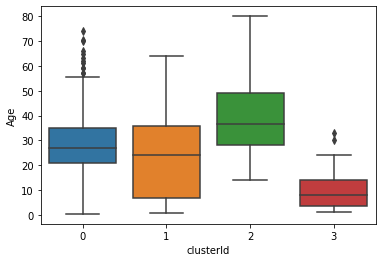

In [51]:
sns.boxplot(data=df_clustering, y='Age', x='clusterId')

### Use StandardScaler transformation for our data **X**

In [52]:
enc = sklearn.preprocessing.StandardScaler()
X_stand = enc.fit_transform(X)

In [53]:
X_stand

array([[ 0.75613751, -0.47261792, -0.20232566, ...,  0.90859974,
         0.52251079, -0.50678737],
       [-1.32251077,  2.11587407, -0.20232566, ..., -1.48298257,
         0.52251079, -0.50678737],
       [-1.32251077, -0.47261792, -0.20232566, ...,  0.90859974,
        -0.55271372, -0.50678737],
       ...,
       [-1.32251077, -0.47261792, -0.20232566, ..., -1.48298257,
        -0.55271372, -0.50678737],
       [ 0.75613751,  2.11587407, -0.20232566, ..., -1.48298257,
        -0.55271372, -0.50678737],
       [ 0.75613751, -0.47261792,  4.94252683, ...,  0.90859974,
        -0.55271372, -0.50678737]])

<AxesSubplot:xlabel='k'>

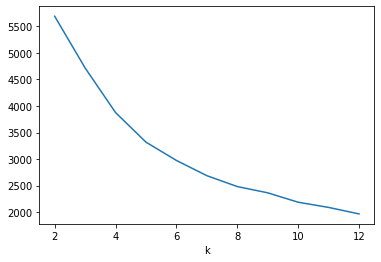

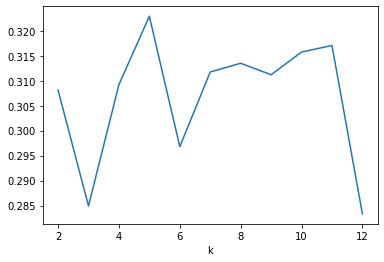

In [54]:
clustering_scores = []

for k in range(2, 13):
    clustering = sklearn.cluster.KMeans(n_clusters=k).fit(X_stand)
    clustering_scores.append({
        'k': k,
        'sse': clustering.inertia_,
        'silh': sklearn.metrics.silhouette_score(X_stand, clustering.labels_)
    })
    
    
df_scores = pd.DataFrame.from_dict(clustering_scores, orient='columns').set_index('k')

df_scores.sse.plot()
plt.figure()
df_scores.silh.plot()

In [55]:
clustering = sklearn.cluster.KMeans(n_clusters=4).fit(X_stand)

In [56]:
pd.Series(clustering.labels_).value_counts()

1    342
0    212
2    130
3     28
dtype: int64

# Explore clusters

In [57]:
df_clustering['clusterId'] = clustering.labels_
df_clustering.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,clusterId
0,0,3,male,22.0,1,0,7.2500,S,1
1,1,1,female,38.0,1,0,71.2833,C,2
2,1,3,female,26.0,0,0,7.9250,S,0
3,1,1,female,35.0,1,0,53.1000,S,0
4,0,3,male,35.0,0,0,8.0500,S,1


<AxesSubplot:xlabel='clusterId', ylabel='count'>

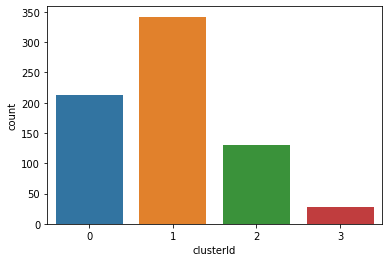

In [58]:
sns.countplot(data=df_clustering, x='clusterId')

<AxesSubplot:xlabel='clusterId', ylabel='count'>

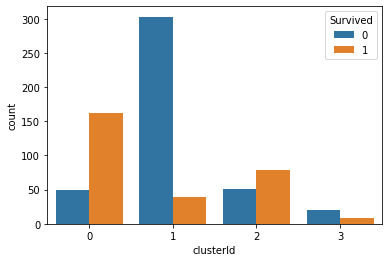

In [59]:
sns.countplot(data=df_clustering, x='clusterId', hue='Survived')

<AxesSubplot:xlabel='clusterId', ylabel='count'>

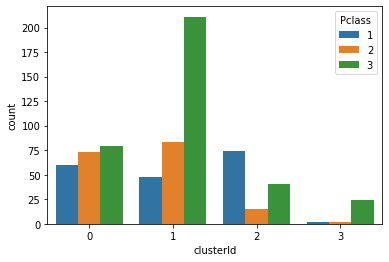

In [60]:
sns.countplot(data=df_clustering, x='clusterId', hue='Pclass')

- z rychliku
- kouzelna formule :D

In [61]:
with pd.option_context('display.max_columns', None):
    display(df_clustering.groupby('clusterId').describe())

Survived                                              Pclass  \
             count      mean       std  min  25%  50%  75%  max  count   
clusterId                                                                
0            212.0  0.764151  0.425533  0.0  1.0  1.0  1.0  1.0  212.0   
1            342.0  0.114035  0.318320  0.0  0.0  0.0  0.0  1.0  342.0   
2            130.0  0.607692  0.490153  0.0  0.0  1.0  1.0  1.0  130.0   
3             28.0  0.285714  0.460044  0.0  0.0  0.0  1.0  1.0   28.0   

                                                          Age             \
               mean       std  min  25%  50%  75%  max  count       mean   
clusterId                                                                  
0          2.089623  0.806658  1.0  1.0  2.0  3.0  3.0  212.0  24.748821   
1          2.476608  0.729184  1.0  2.0  3.0  3.0  3.0  342.0  32.356725   
2          1.746154  0.909140  1.0  1.0  1.0  3.0  3.0  130.0  30.814769   
3          2.785714  0.568112  1.0  3.0  3.0  3.0  3.0   28.0  28.089286   

                                                      SibSp            \
                 std    min    25%   50%   75%   max  count      mean   
clusterId                                                               
0          15.218947   0.67  11.00  25.5  35.0  64.0  212.0  1.023585   
1          12.603877  14.00  22.00  29.0  39.0  80.0  342.0  0.213450   
2          15.434860   0.42  21.25  29.0  40.0  71.0  130.0  0.423077   
3          16.915396   2.00  17.50  27.0  34.5  70.5   28.0  0.750000   

                                              Parch                           \
                std  min  25%  50%  75%  max  count      mean       std  min   
clusterId                                                                      
0          1.293223  0.0  0.0  1.0  1.0  5.0  212.0  1.028302  1.155720  0.0   
1          0.476479  0.0  0.0  0.0  0.0  2.0  342.0  0.073099  0.292489  0.0   
2          0.568766  0.0  0.0  0.0  1.0  2.0  130.0  0.415385  0.690855  0.0   
3          1.430488  0.0  0.0  0.0  1.0  4.0   28.0  0.392857  0.994030  0.0   

                                 Fare                                         \
           25%  50%   75%  max  count       mean        std     min      25%   
clusterId                                                                      
0          0.0  1.0  2.00  6.0  212.0  44.925472  50.164402  7.2500  15.9750   
1          0.0  0.0  0.00  2.0  342.0  16.659829  17.385686  0.0000   7.8958   
2          0.0  0.0  1.00  3.0  130.0  68.296767  90.557822  4.0125  14.4542   
3          0.0  0.0  0.25  5.0   28.0  18.265775  21.843582  6.7500   7.7500   

                                         
                50%       75%       max  
clusterId                                
0          26.26665  48.04480  263.0000  
1           9.50000  16.10000  153.4625  
2          36.25210  81.42810  512.3292  
3           7.75000  18.90625   90.0000

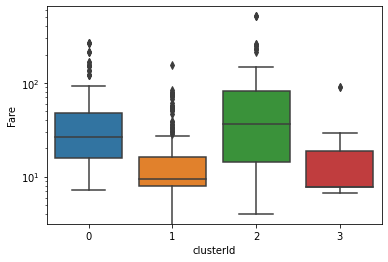

In [62]:
sns.boxplot(data=df_clustering, y='Fare', x='clusterId')
plt.yscale('log')

<AxesSubplot:xlabel='clusterId', ylabel='Age'>

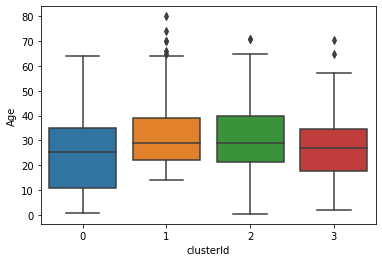

In [63]:
sns.boxplot(data=df_clustering, y='Age', x='clusterId')

## Projekt

- Můžeme si vybrat jakýkoliv ds
- Inspirace https://homel.vsb.cz/~svo0175/eda_project.html
- Udělat explorační analýzy, předpoklady a podobně, udělat závěr co jsme tam udělali 
- Vyzkoušet si shlukování